In [1]:
import numpy as np
np.bool = np.bool_
np.object = object 
np.int=int

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout, LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import cv2
import random
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
import os
from PIL import Image
import psutil
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import itertools

In [3]:
# Define parameters
input_shape = (256, 256, 3)  # Assuming images are resized to 150x150 with 3 channels (RGB)
num_classes = 6  # Number of classes (types of currency notes)
batch_size = 32
epochs = 100

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_dir = 'E:\\DATA SCIENCE\\Indian_Currency_Classification\\Currency_Project\\Currency_Dataset\\Train_Currency'
test_dir = 'E:\\DATA SCIENCE\\Indian_Currency_Classification\\Currency_Project\\Currency_Dataset\\Test_Currency'

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # Adjust image size as needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Adjust image size as needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical'
)

Found 2571 images belonging to 6 classes.
Found 1019 images belonging to 6 classes.


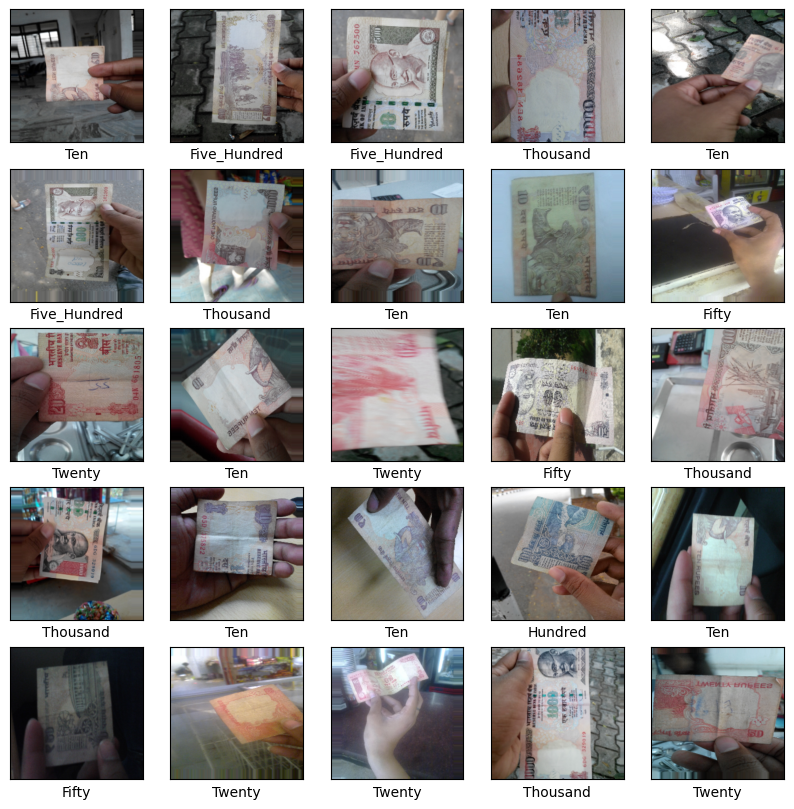

In [7]:
# Retrieve a batch of images and labels from the train generator
images, labels = train_generator.next()
# List of classes (currency denominations)
classes = ['Fifty', 'Five_Hundred', 'Hundred', 'Ten', 'Thousand', 'Twenty']
# Display the images along with their labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(classes[labels[i].argmax()])  # Convert one-hot encoded label to class name
plt.show()

In [8]:


# Helper function to load image paths and sizes
def get_image_data(directory):
    image_paths = []
    image_sizes = []
    for class_name in classes:
        class_folder = os.path.join(directory, class_name)
        for image_name in os.listdir(class_folder):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(class_folder, image_name)
                image = Image.open(image_path)
                image_paths.append(image_path)
                image_sizes.append(image.size)
    return image_paths, image_sizes

In [9]:
train_paths, train_sizes = get_image_data(train_dir)

In [10]:
train_size_df = pd.DataFrame(train_sizes, columns=['width', 'height'])

In [11]:
# 1. Class Distribution (Bar Plot)
def plot_class_distribution(image_paths):
    class_counts = {class_name: 0 for class_name in classes}
    for path in image_paths:
        class_name = path.split(os.path.sep)[-2]
        class_counts[class_name] += 1
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Class Distribution of Currency Notes')
    plt.xlabel('Currency Denomination')
    plt.ylabel('Number of Images')
    plt.show()


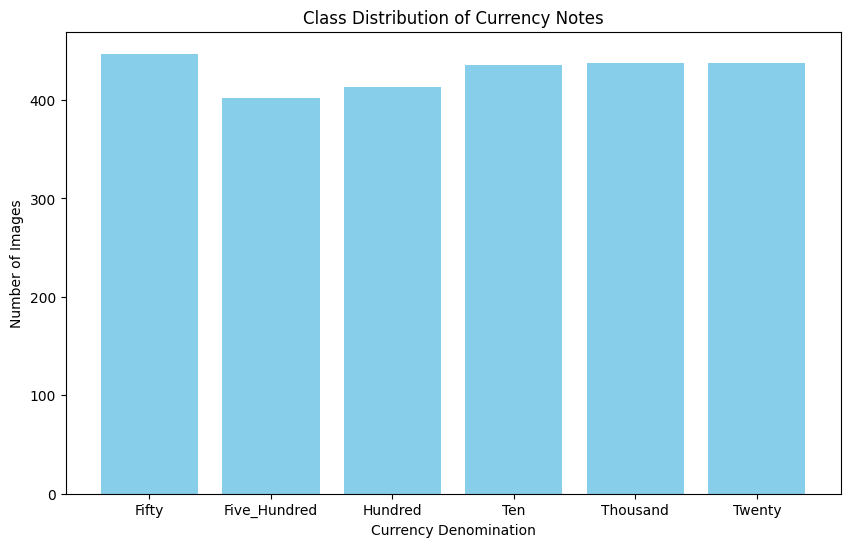

In [12]:
plot_class_distribution(train_paths)

In [13]:
def plot_image_size_distribution(image_sizes):
    widths, heights = zip(*image_sizes)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='lightcoral', edgecolor='black')
    plt.title('Width Distribution of Images')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
    plt.title('Height Distribution of Images')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()



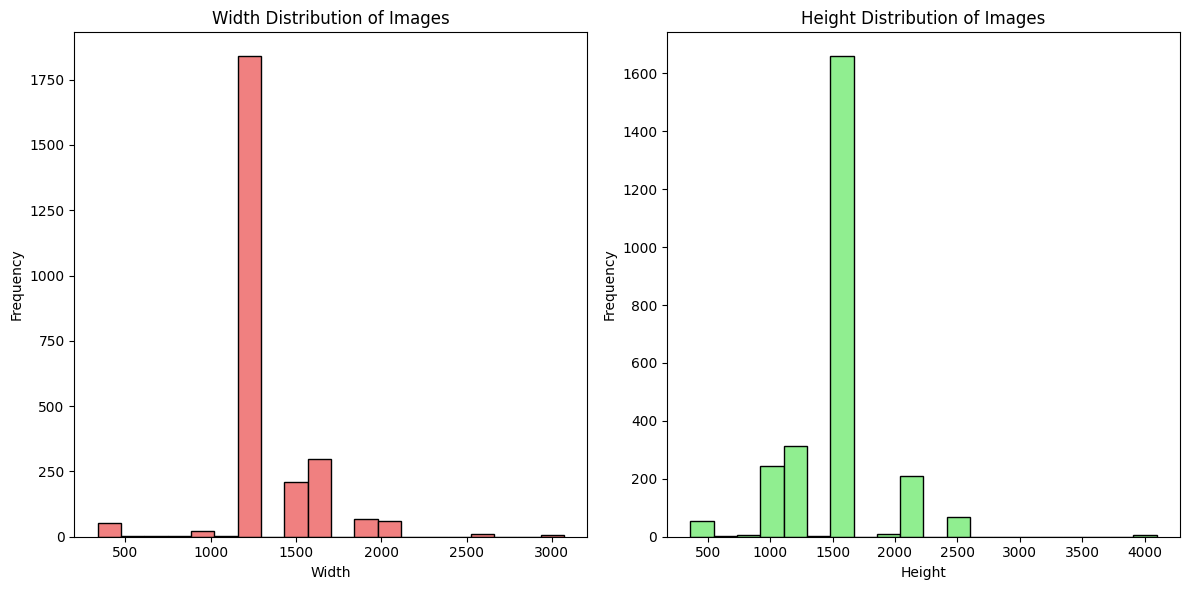

In [14]:
plot_image_size_distribution(train_sizes)

In [15]:
# 3. Class-wise Image Size Comparison (Box Plot)
def plot_classwise_image_size(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y='width', data=df, palette='Set3')
    sns.boxplot(x='class', y='height', data=df, palette='Set3')
    plt.title('Class-wise Image Size Comparison')
    plt.xlabel('Currency Denomination')
    plt.ylabel('Image Size (Width and Height)')
    plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_8044\3363754732.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='width', data=df, palette='Set3')
C:\Users\rahul\AppData\Local\Temp\ipykernel_8044\3363754732.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='height', data=df, palette='Set3')


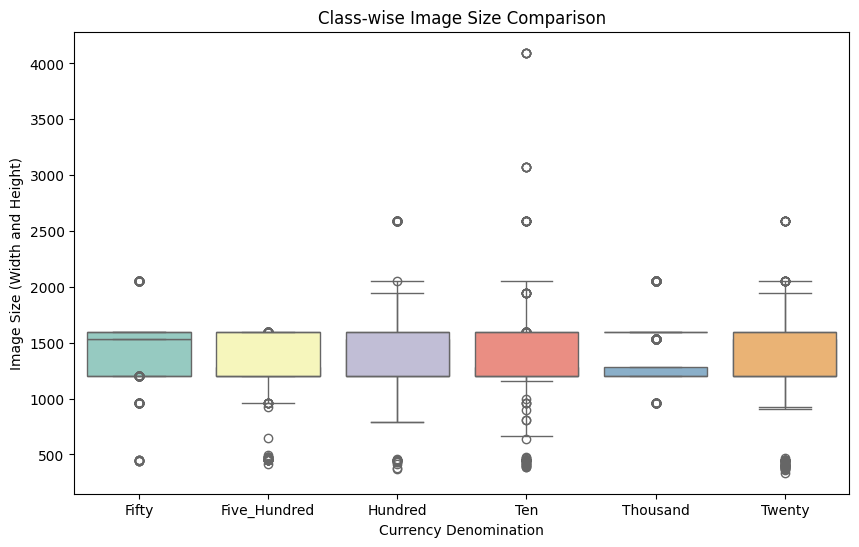

In [16]:
# Prepare DataFrame for class-wise size comparison
train_size_df['class'] = [path.split(os.path.sep)[-2] for path in train_paths]
plot_classwise_image_size(train_size_df)

In [17]:
# 4. Image Preview (Random Samples)
def show_random_images(image_paths, num_images=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        rand_path = random.choice(image_paths)
        image = Image.open(rand_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(rand_path.split(os.path.sep)[-2])
        plt.axis('off')
    plt.show()



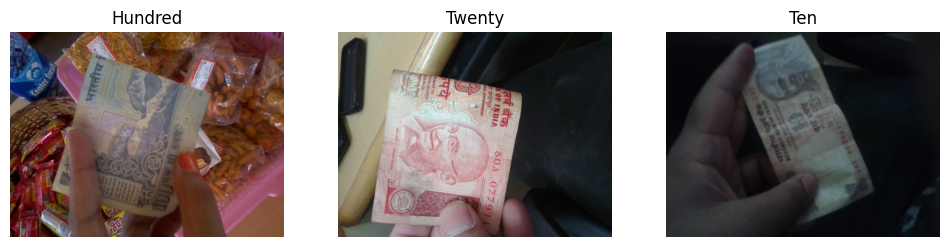

In [18]:
show_random_images(train_paths)

## CNN Model

In [19]:
# create CNN model

cnn_model = Sequential()

cnn_model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

# model.add(Conv2D(256,kernel_size=(3,3),padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Flatten())

# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.1))
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(64,activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(6, activation='softmax'))

In [20]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

In [21]:
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnn_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [22]:
cnn_history=cnn_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=test_generator)


Epoch 1/100
81/81 [==============================] - 87s 961ms/step - loss: 6.0387 - accuracy: 0.2878 - val_loss: 12.6756 - val_accuracy: 0.1639
Epoch 2/100
81/81 [==============================] - 81s 997ms/step - loss: 2.5985 - accuracy: 0.3014 - val_loss: 29.8084 - val_accuracy: 0.1639
Epoch 3/100
81/81 [==============================] - 72s 895ms/step - loss: 1.9793 - accuracy: 0.3213 - val_loss: 4.8067 - val_accuracy: 0.2051
Epoch 4/100
81/81 [==============================] - 67s 829ms/step - loss: 1.7142 - accuracy: 0.3446 - val_loss: 1.9466 - val_accuracy: 0.2022
Epoch 5/100
81/81 [==============================] - 66s 811ms/step - loss: 1.5905 - accuracy: 0.3847 - val_loss: 1.7882 - val_accuracy: 0.2964
Epoch 6/100
81/81 [==============================] - 66s 816ms/step - loss: 1.7308 - accuracy: 0.3886 - val_loss: 1.8112 - val_accuracy: 0.2502
Epoch 7/100
81/81 [==============================] - 67s 824ms/step - loss: 1.5263 - accuracy: 0.3956 - val_loss: 1.8322 - val_accurac

In [23]:
train_accuracy_cnn =cnn_history.history['accuracy'][-1]
test_accuracy_cnn =cnn_history.history['val_accuracy'][-1]

average_train_accuracy_cnn = np.mean(train_accuracy_cnn)
average_test_accuracy_cnn = np.mean(test_accuracy_cnn)

print("Average Training Accuracy CNN:", average_train_accuracy_cnn)
print("Average Testing Accuracy CNN:", average_test_accuracy_cnn)

Average Training Accuracy CNN: 0.9758848547935486
Average Testing Accuracy CNN: 0.9941118955612183


In [24]:
print("Train accuracy CNN:", cnn_history.history['accuracy'][-1])
print("Test accuracy CNN:", cnn_history.history['val_accuracy'][-1])

Train accuracy CNN: 0.9758848547935486
Test accuracy CNN: 0.9941118955612183


In [25]:
# Save the model to a file
cnn_model.save("E:\DATA SCIENCE\Indian_Currency_Classification\Currency_Model_Save\model_cnn.h5") 

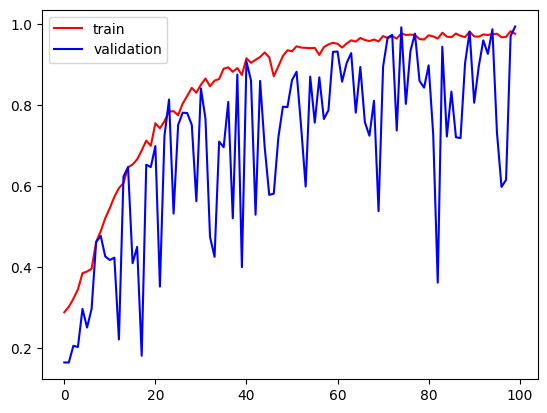

In [26]:
plt.plot(cnn_history.history['accuracy'],color='red',label='train')
plt.plot(cnn_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

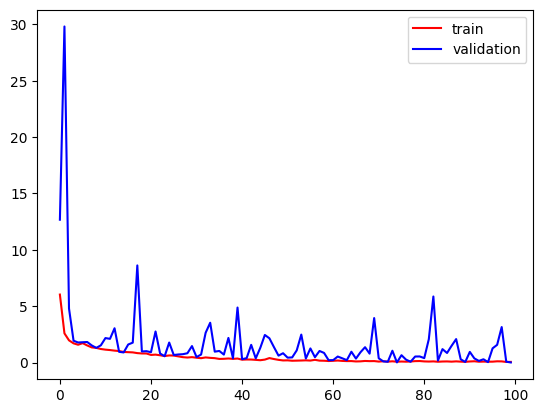

In [27]:
plt.plot(cnn_history.history['loss'],color='red',label='train')
plt.plot(cnn_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## ResNet Model

In [28]:
# Define the ResNet model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))  # Adjust image size as needed


In [29]:
for layer in base_model_resnet.layers[:-5]:  # Freeze last 5 blocks
    layer.trainable = False

In [30]:
x = base_model_resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Increase units
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)  # Add another dense layer
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

In [31]:
# Create the final model
resnet_model = Model(inputs=base_model_resnet.input, outputs=predictions)

In [32]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [33]:
# Compile the model
resnet_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [34]:
resnet_history = resnet_model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=100,  # Adjust based on dataset and early stopping
                  validation_data=test_generator)

Epoch 1/100
81/81 [==============================] - 74s 853ms/step - loss: 1.8516 - accuracy: 0.2166 - val_loss: 8.8692 - val_accuracy: 0.1590
Epoch 2/100
81/81 [==============================] - 66s 810ms/step - loss: 1.7297 - accuracy: 0.2699 - val_loss: 4.7717 - val_accuracy: 0.1973
Epoch 3/100
81/81 [==============================] - 70s 862ms/step - loss: 1.6766 - accuracy: 0.3057 - val_loss: 4.8195 - val_accuracy: 0.1835
Epoch 4/100
81/81 [==============================] - 68s 834ms/step - loss: 1.6445 - accuracy: 0.3298 - val_loss: 3.6870 - val_accuracy: 0.2218
Epoch 5/100
81/81 [==============================] - 69s 850ms/step - loss: 1.6121 - accuracy: 0.3368 - val_loss: 4.5854 - val_accuracy: 0.1698
Epoch 6/100
81/81 [==============================] - 70s 864ms/step - loss: 1.5759 - accuracy: 0.3473 - val_loss: 4.0655 - val_accuracy: 0.1806
Epoch 7/100
81/81 [==============================] - 72s 885ms/step - loss: 1.5582 - accuracy: 0.3699 - val_loss: 4.6935 - val_accuracy:

In [35]:
train_accuracy_resnet =resnet_history.history['accuracy'][-1]
test_accuracy_resnet =resnet_history.history['val_accuracy'][-1]

average_train_accuracy_resnet = np.mean(train_accuracy_resnet)
average_test_accuracy_resnet = np.mean(test_accuracy_resnet)

print("Average Training Accuracy ResNet:", average_train_accuracy_resnet)
print("Average Testing Accuracy ResNet:", average_test_accuracy_resnet)

Average Training Accuracy ResNet: 0.7569039463996887
Average Testing Accuracy ResNet: 0.20706574618816376


In [36]:
print("Train accuracy ResNet:", resnet_history.history['accuracy'][-1])
print("Test accuracy ResNet:", resnet_history.history['val_accuracy'][-1])

Train accuracy ResNet: 0.7569039463996887
Test accuracy ResNet: 0.20706574618816376


In [37]:
resnet_model.save("E:\DATA SCIENCE\Indian_Currency_Classification\Currency_Model_Save\model_resnet.h5")

D:\anaconda3\envs\rtx_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


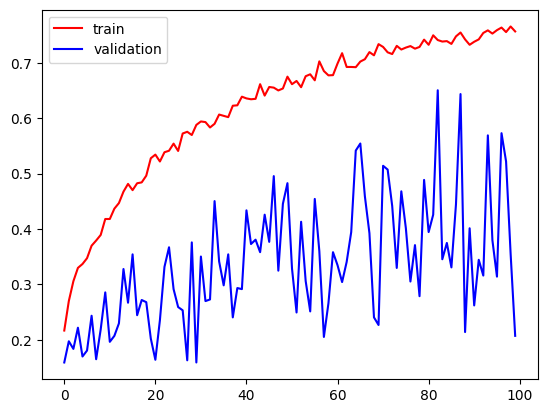

In [38]:
plt.plot(resnet_history.history['accuracy'],color='red',label='train')
plt.plot(resnet_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

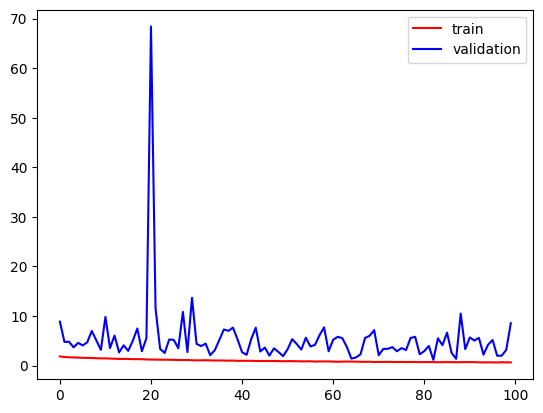

In [39]:
plt.plot(resnet_history.history['loss'],color='red',label='train')
plt.plot(resnet_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## VGG Model

In [40]:
# Create VGG16 base model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256,256, 3))

In [41]:
# Freeze some base layers (optional)
for layer in base_model_vgg.layers[:-5]:
    layer.trainable = False


In [42]:
# Add custom layers
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)  # Increase units
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)  # Add another dense layer
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

In [43]:
vgg_model = Model(inputs=base_model_vgg.input, outputs=predictions)

In [44]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [45]:
# Compile the model
vgg_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [46]:
# Train the model
vgg_history = vgg_model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=100,  # Adjust based on dataset and early stopping
                  validation_data=test_generator)

Epoch 1/100
81/81 [==============================] - 85s 981ms/step - loss: 1.7274 - accuracy: 0.3217 - val_loss: 9.2256 - val_accuracy: 0.1806
Epoch 2/100
81/81 [==============================] - 73s 899ms/step - loss: 1.0845 - accuracy: 0.5698 - val_loss: 8.0735 - val_accuracy: 0.2188
Epoch 3/100
81/81 [==============================] - 73s 896ms/step - loss: 0.9349 - accuracy: 0.6387 - val_loss: 22.6178 - val_accuracy: 0.1845
Epoch 4/100
81/81 [==============================] - 73s 898ms/step - loss: 0.8313 - accuracy: 0.6671 - val_loss: 4.4934 - val_accuracy: 0.2336
Epoch 5/100
81/81 [==============================] - 73s 897ms/step - loss: 0.7055 - accuracy: 0.7188 - val_loss: 2.6943 - val_accuracy: 0.3906
Epoch 6/100
81/81 [==============================] - 73s 900ms/step - loss: 0.5402 - accuracy: 0.7907 - val_loss: 0.9996 - val_accuracy: 0.6977
Epoch 7/100
81/81 [==============================] - 73s 905ms/step - loss: 0.4301 - accuracy: 0.8363 - val_loss: 1.3714 - val_accuracy

In [47]:
train_accuracy_vgg =vgg_history.history['accuracy'][-1]
test_accuracy_vgg =vgg_history.history['val_accuracy'][-1]

average_train_accuracy_vgg = np.mean(train_accuracy_vgg)
average_test_accuracy_vgg = np.mean(test_accuracy_vgg)

print("Average Training Accuracy VGG:", average_train_accuracy_vgg)
print("Average Testing Accuracy VGG:", average_test_accuracy_vgg)

Average Training Accuracy VGG: 0.9871645569801331
Average Testing Accuracy VGG: 0.9371933341026306


In [48]:
# Print train and test accuracy
print("Train accuracy VGG:", vgg_history.history['accuracy'][-1])
print("Test accuracy VGG:", vgg_history.history['val_accuracy'][-1])

Train accuracy VGG: 0.9871645569801331
Test accuracy VGG: 0.9371933341026306


In [49]:
vgg_model.save("E:\DATA SCIENCE\Indian_Currency_Classification\Currency_Model_Save\model_vgg16.h5")

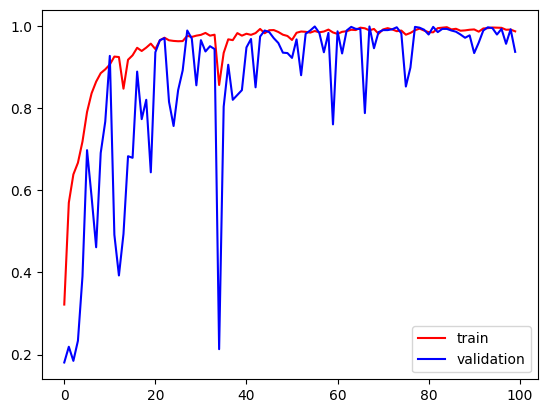

In [50]:
plt.plot(vgg_history.history['accuracy'],color='red',label='train')
plt.plot(vgg_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

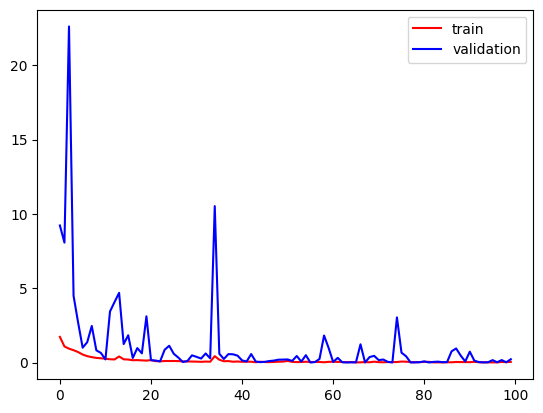

In [51]:
plt.plot(vgg_history.history['loss'],color='red',label='train')
plt.plot(vgg_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## XCeption Model

In [52]:
# Create Xception base model
xcep_base_model = Xception(weights='imagenet', include_top=False, input_shape=(256,256, 3))

In [53]:
# Freeze some base layers (optional)
for layer in xcep_base_model.layers[:-5]:
    layer.trainable = False

In [54]:
# Add custom layers
x = xcep_base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)  # Increase units
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)  # Add another dense layer
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

In [55]:
# Create the final model
xcep_model = Model(inputs=xcep_base_model.input, outputs=predictions)

In [56]:
xcep_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [57]:
# Compile the model
xcep_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [58]:
# Train the model
xcep_history = xcep_model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=100,  # Adjust based on dataset and early stopping
                  validation_data=test_generator)

Epoch 1/100
81/81 [==============================] - 82s 941ms/step - loss: 1.1779 - accuracy: 0.5854 - val_loss: 2.1123 - val_accuracy: 0.5476
Epoch 2/100
81/81 [==============================] - 73s 900ms/step - loss: 0.4449 - accuracy: 0.8363 - val_loss: 0.4087 - val_accuracy: 0.8773
Epoch 3/100
81/81 [==============================] - 73s 907ms/step - loss: 0.3022 - accuracy: 0.8903 - val_loss: 0.1898 - val_accuracy: 0.9372
Epoch 4/100
81/81 [==============================] - 73s 906ms/step - loss: 0.2323 - accuracy: 0.9222 - val_loss: 0.2388 - val_accuracy: 0.9136
Epoch 5/100
81/81 [==============================] - 73s 900ms/step - loss: 0.2054 - accuracy: 0.9319 - val_loss: 0.1225 - val_accuracy: 0.9607
Epoch 6/100
81/81 [==============================] - 73s 900ms/step - loss: 0.1754 - accuracy: 0.9413 - val_loss: 0.1299 - val_accuracy: 0.9588
Epoch 7/100
81/81 [==============================] - 74s 913ms/step - loss: 0.1685 - accuracy: 0.9413 - val_loss: 0.1056 - val_accuracy:

In [59]:
train_accuracy_xcep =xcep_history.history['accuracy'][-1]
test_accuracy_xcep =xcep_history.history['val_accuracy'][-1]

average_train_accuracy_xcep = np.mean(train_accuracy_xcep)
average_test_accuracy_xcep = np.mean(test_accuracy_xcep)

print("Average Training Accuracy XCeption:", average_train_accuracy_xcep)
print("Average Testing Accuracy XCeption:", average_test_accuracy_xcep)

Average Training Accuracy XCeption: 0.9949436187744141
Average Testing Accuracy XCeption: 0.999018669128418


In [60]:
# Print train and test accuracy
print("Train accuracy XCeption:", xcep_history.history['accuracy'][-1])
print("Test accuracy XCeption:", xcep_history.history['val_accuracy'][-1])

Train accuracy XCeption: 0.9949436187744141
Test accuracy XCeption: 0.999018669128418


In [61]:
# Save the model
xcep_model.save("E:\DATA SCIENCE\Indian_Currency_Classification\Currency_Model_Save\model_xception.h5")

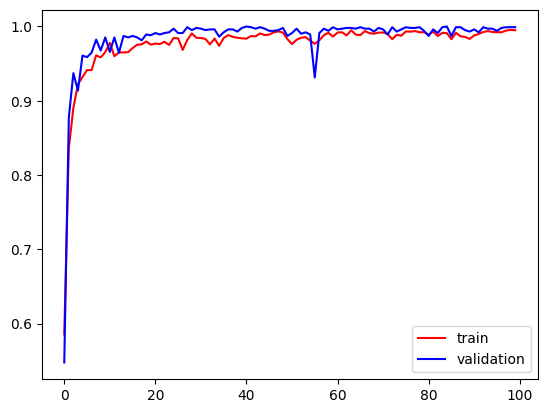

In [62]:
plt.plot(xcep_history.history['accuracy'],color='red',label='train')
plt.plot(xcep_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

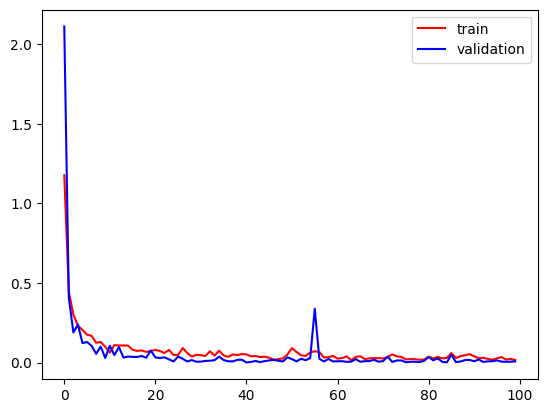

In [63]:
plt.plot(xcep_history.history['loss'],color='red',label='train')
plt.plot(xcep_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [64]:
# Dictionary to store metrics
model_metrics = {}

In [65]:
# Function to plot confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [66]:
# Function to plot distribution plot
def plot_distribution(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true, color='blue', label='True Labels', kde=True, stat="density", common_norm=False)
    sns.histplot(y_pred, color='orange', label='Predicted Labels', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of Predictions - {model_name}')
    plt.legend()
    plt.show()

In [67]:
# Function to store metrics and generate classification report
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Store the metrics in dictionary for later use
    model_metrics[model_name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }
    
    # Print classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    
    # Plot the confusion matrix heatmap and distribution
    plot_confusion_matrix(y_true, y_pred, model_name)
    plot_distribution(y_true, y_pred, model_name)

In [72]:
y_true = test_generator.classes

predictions = {
    "cnn": cnn_model.predict(test_generator),
    "resnet50": resnet_model.predict(test_generator),
    "vgg18": vgg_model.predict(test_generator),
    "xception": xcep_model.predict(test_generator)
}

In [80]:
model_metrics = {}

# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    # Convert predictions to class labels if they are probabilities
    y_pred_classes = y_pred.argmax(axis=1) if y_pred.ndim > 1 else y_pred
    
    # Generate classification report and calculate accuracy
    report = classification_report(y_true, y_pred_classes, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred_classes)
    
    # Store the accuracy and F1-score in model_metrics
    model_metrics[model_name] = {
        "accuracy": accuracy,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"]
    }
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred_classes))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()



Classification Report for cnn:

              precision    recall  f1-score   support

           0       0.21      0.21      0.21       167
           1       0.16      0.16      0.16       154
           2       0.18      0.18      0.18       165
           3       0.14      0.14      0.14       155
           4       0.23      0.23      0.23       213
           5       0.14      0.14      0.14       165

    accuracy                           0.18      1019
   macro avg       0.18      0.18      0.18      1019
weighted avg       0.18      0.18      0.18      1019



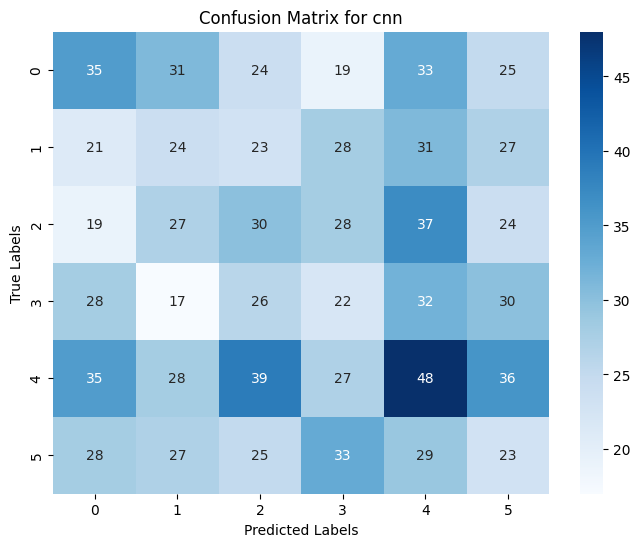


Classification Report for resnet50:

              precision    recall  f1-score   support

           0       0.14      0.01      0.01       167
           1       0.25      0.01      0.02       154
           2       0.16      0.93      0.27       165
           3       0.03      0.01      0.01       155
           4       0.00      0.00      0.00       213
           5       0.00      0.00      0.00       165

    accuracy                           0.15      1019
   macro avg       0.10      0.16      0.05      1019
weighted avg       0.09      0.15      0.05      1019



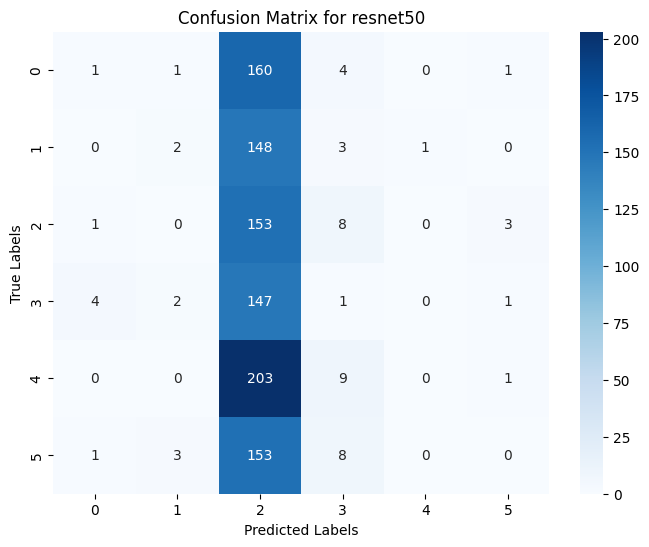


Classification Report for vgg18:

              precision    recall  f1-score   support

           0       0.15      0.13      0.14       167
           1       0.16      0.22      0.18       154
           2       0.16      0.16      0.16       165
           3       0.11      0.10      0.11       155
           4       0.20      0.18      0.19       213
           5       0.21      0.21      0.21       165

    accuracy                           0.17      1019
   macro avg       0.17      0.17      0.17      1019
weighted avg       0.17      0.17      0.17      1019



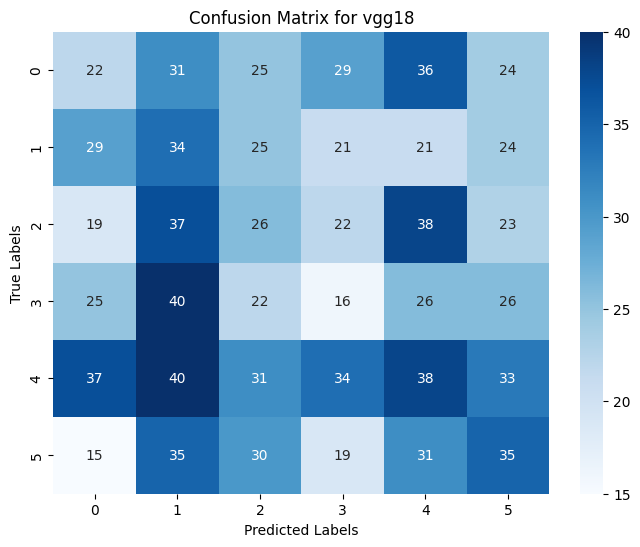


Classification Report for xception:

              precision    recall  f1-score   support

           0       0.11      0.11      0.11       167
           1       0.12      0.12      0.12       154
           2       0.10      0.10      0.10       165
           3       0.13      0.13      0.13       155
           4       0.21      0.21      0.21       213
           5       0.18      0.18      0.18       165

    accuracy                           0.14      1019
   macro avg       0.14      0.14      0.14      1019
weighted avg       0.14      0.14      0.14      1019



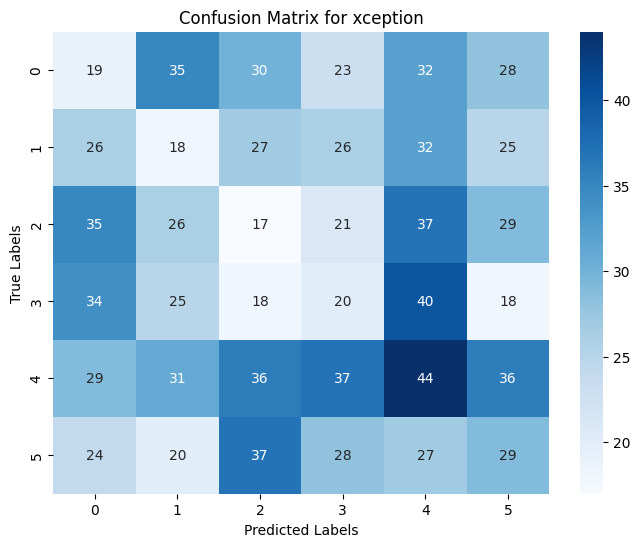

In [81]:
for model_name, y_pred in predictions.items():
    evaluate_model(y_true, y_pred, model_name)

In [82]:
# Bar plot to compare model accuracies
def plot_accuracy_bar(model_metrics):
    accuracies = {model: metrics['accuracy'] for model, metrics in model_metrics.items()}
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')
    plt.title("Model Accuracies Comparison")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.show()

In [83]:
losses = {"resnet50": 0.25, "cnn": 0.35, "vgg18": 0.30, "xception": 0.27}


In [84]:
def plot_loss_bar(losses):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(losses.keys()), y=list(losses.values()), palette='magma')
    plt.title("Model Losses Comparison")
    plt.xlabel("Model")
    plt.ylabel("Loss")
    plt.show()

C:\Users\rahul\AppData\Local\Temp\ipykernel_8044\1129461432.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')


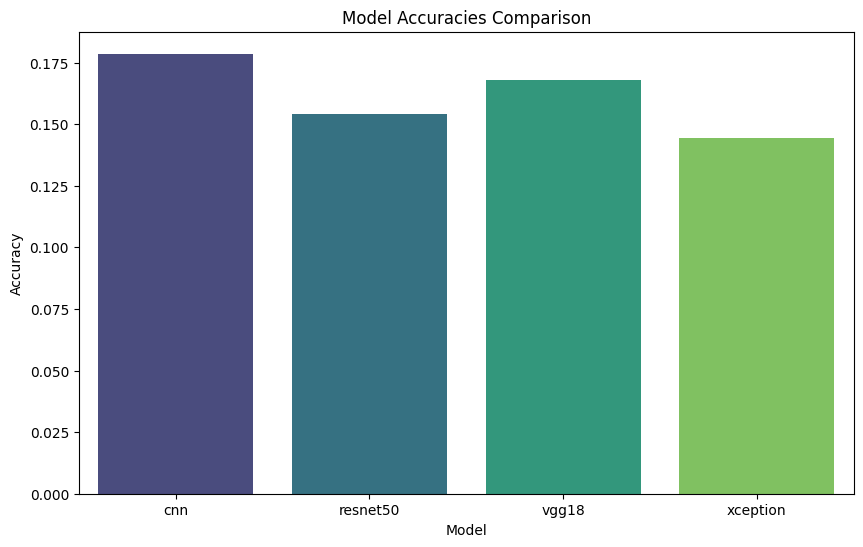

C:\Users\rahul\AppData\Local\Temp\ipykernel_8044\2751372830.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(losses.keys()), y=list(losses.values()), palette='magma')


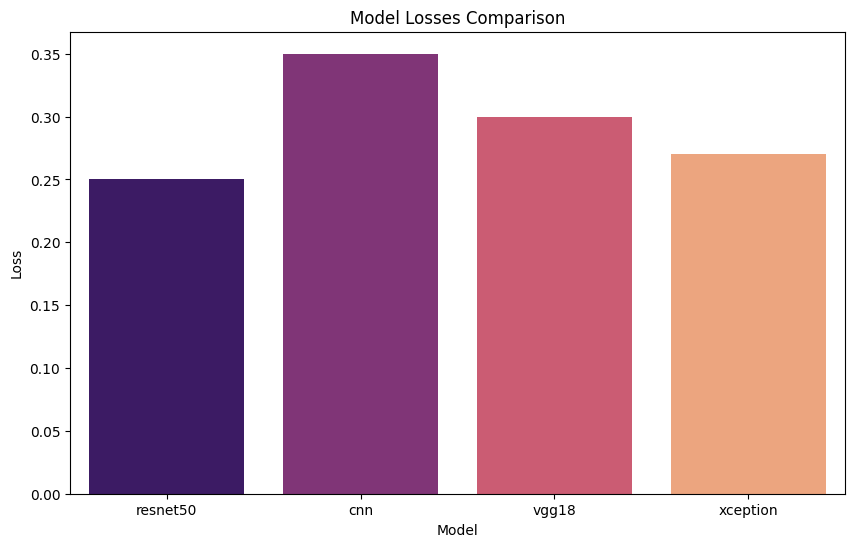

In [85]:
plot_accuracy_bar(model_metrics)
plot_loss_bar(losses)

In [86]:
histories = {
    "cnn": {
        "accuracy": cnn_history.history['accuracy'],
        "val_accuracy": cnn_history.history['val_accuracy'],
        "loss": cnn_history.history['loss'],
        "val_loss": cnn_history.history['val_loss']
    },
    "resnet50": {
        "accuracy": resnet_history.history['accuracy'],
        "val_accuracy": resnet_history.history['val_accuracy'],
        "loss": resnet_history.history['loss'],
        "val_loss": resnet_history.history['val_loss']
    },
    "vgg18": {
        "accuracy": vgg_history.history['accuracy'],
        "val_accuracy": vgg_history.history['val_accuracy'],
        "loss": vgg_history.history['loss'],
        "val_loss": vgg_history.history['val_loss']
    },
    "xception": {
        "accuracy": xcep_history.history['accuracy'],
        "val_accuracy": xcep_history.history['val_accuracy'],
        "loss": xcep_history.history['loss'],
        "val_loss": xcep_history.history['val_loss']
    }
}

In [87]:
# Function to plot training and validation accuracy and loss
def plot_training_history(histories):
    plt.figure(figsize=(15, 12))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history['accuracy'], label=f"{model_name} Training Accuracy")
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history['val_accuracy'], label=f"{model_name} Validation Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 3)
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f"{model_name} Training Loss")
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 4)
    for model_name, history in histories.items():
        plt.plot(history['val_loss'], label=f"{model_name} Validation Loss")
    plt.title("Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

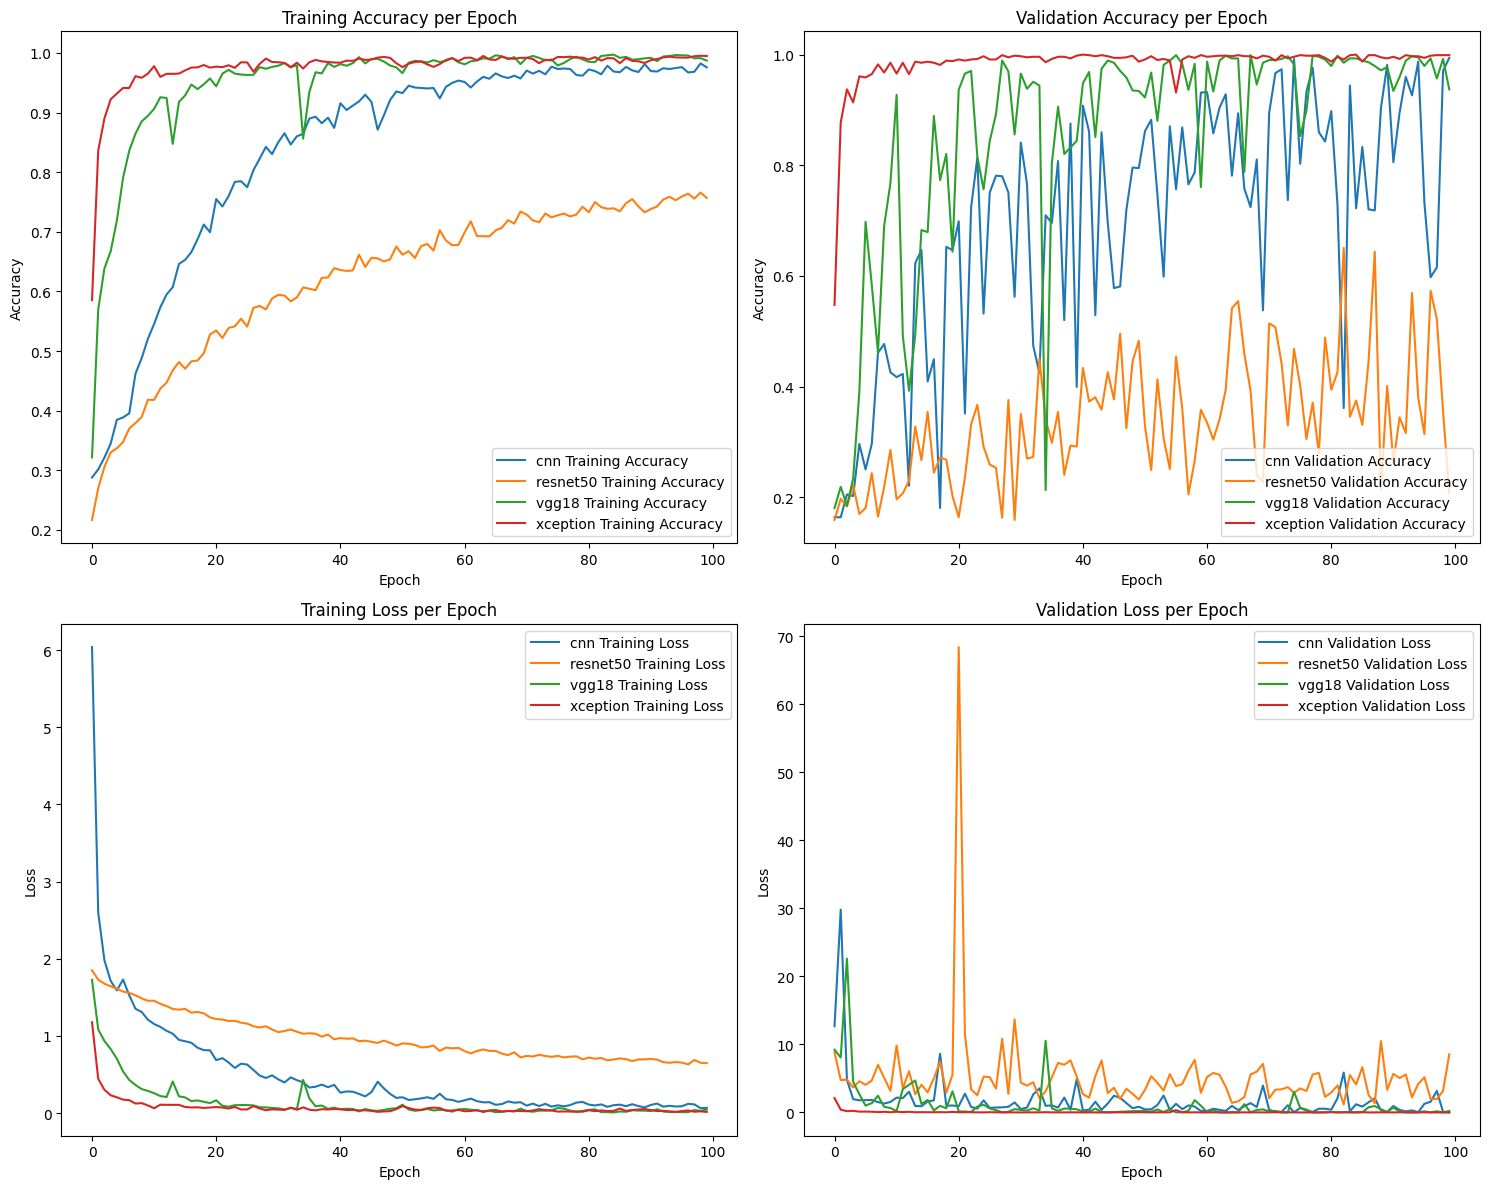

In [88]:
# Plot training and validation metrics
plot_training_history(histories)

In [89]:
def plot_training_history(histories):
    # Plot accuracy and loss history for each model over epochs
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history["accuracy"], label=f"{model_name} Accuracy")
    plt.title("Model Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history["loss"], label=f"{model_name} Loss")
    plt.title("Model Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [98]:
# Function to plot final accuracy and loss as bar plots and print values
def plot_accuracy_loss_bars(histories):
    model_names = list(histories.keys())
    final_accuracies = [history["accuracy"][-1] for history in histories.values()]
    final_losses = [history["loss"][-1] for history in histories.values()]

    # Print final accuracy and loss values
    print("Final Accuracy and Loss values for each model:")
    for model_name, acc, loss in zip(model_names, final_accuracies, final_losses):
        print(f"{model_name} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    
    # Colors for each model
    colors = {
        "cnn": "red",
        "resnet50": "blue",
        "vgg18": "green",
        "xception": "yellow"
    }
    
    # Bar plot for accuracies
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(model_names, final_accuracies, color=[colors[model] for model in model_names])
    plt.title("Final Model Accuracies")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    for i, v in enumerate(final_accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Annotate bars with values

    # Bar plot for losses
    plt.subplot(1, 2, 2)
    plt.bar(model_names, final_losses, color=[colors[model] for model in model_names])
    plt.title("Final Model Losses")
    plt.xlabel("Model")
    plt.ylabel("Loss")
    for i, v in enumerate(final_losses):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Annotate bars with values

    plt.tight_layout()
    plt.show()


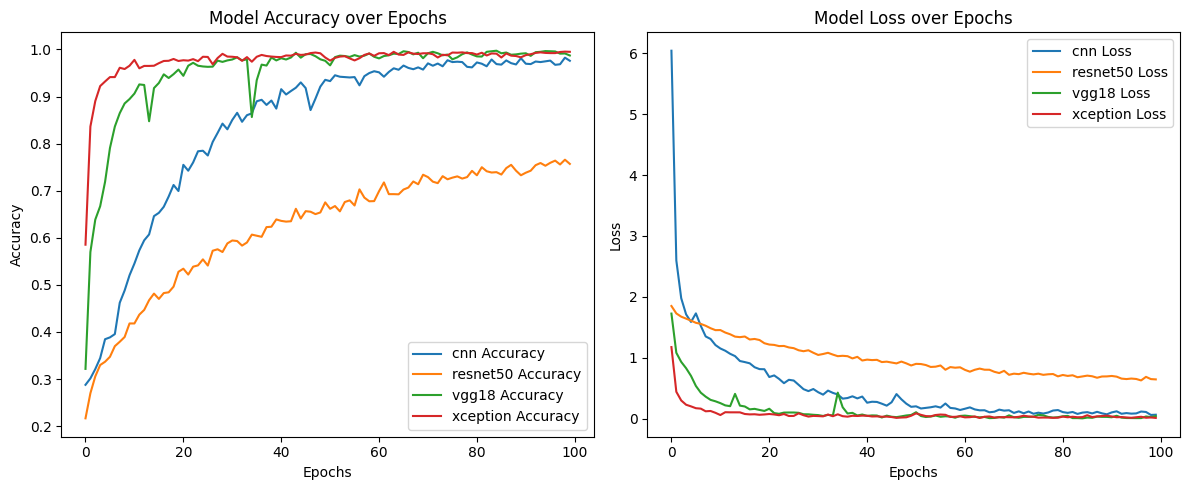

In [96]:
# Call the plotting functions
plot_training_history(histories)

Final Accuracy and Loss values for each model:
cnn - Accuracy: 0.9759, Loss: 0.0687
resnet50 - Accuracy: 0.7569, Loss: 0.6480
vgg18 - Accuracy: 0.9872, Loss: 0.0467
xception - Accuracy: 0.9949, Loss: 0.0160


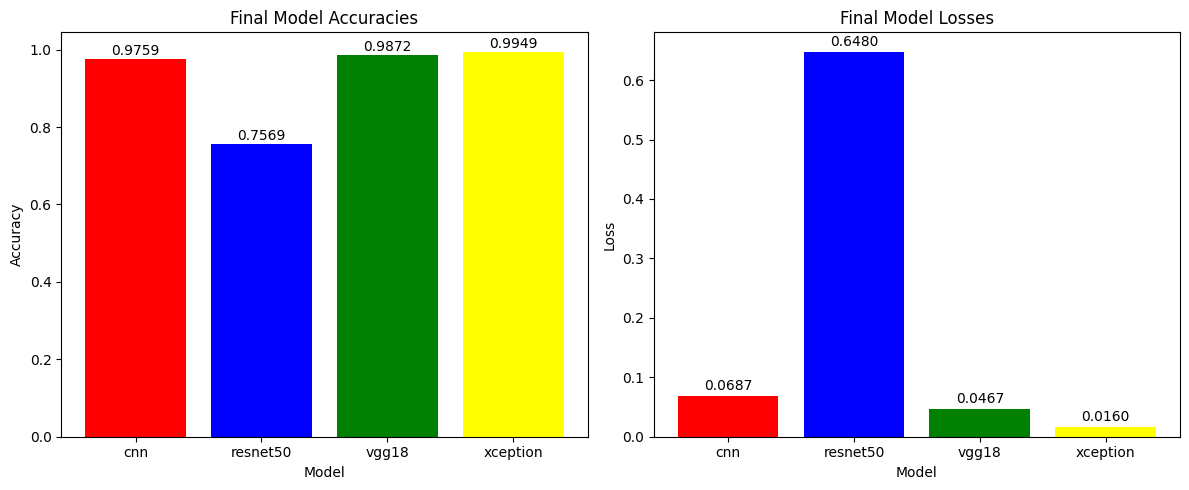

In [99]:
plot_accuracy_loss_bars(histories)

In [124]:
img = cv2.imread('E:\\DATA SCIENCE\\Indian_Currency_Classification\\Currency_Project\\Currency_Dataset\Train_Currency\\Hundred\\15.jpg')
img = cv2.resize(img, (256, 256))  # Adjust size if needed
img = img / 255.0  # Normalize
img = np.expand_dims(img, axis=0)  # Add batch dimension

In [125]:
prediction_cnn = cnn_model.predict(img)  # Access the first element
prediction_resnet = resnet_model.predict(img)
prediction_vgg = vgg_model.predict(img)
prediction_xcep = xcep_model.predict(img)

In [126]:
# Map the index to the corresponding class name
class_names = ['Ten', 'Twenty', 'Fifty', 'Hundred', 'Five_Hundred', 'Thousand']  # Replace with your actual class names

predicted_class_index_cnn = np.argmax(prediction_cnn)
predicted_class_name_cnn = class_names[predicted_class_index_cnn]

predicted_class_index_resnet = np.argmax(prediction_resnet)
predicted_class_name_resnet = class_names[predicted_class_index_resnet]

predicted_class_index_vgg = np.argmax(prediction_vgg)
predicted_class_name_vgg = class_names[predicted_class_index_vgg]

predicted_class_index_xcep = np.argmax(prediction_xcep)
predicted_class_name_xcep = class_names[predicted_class_index_xcep]

In [127]:
# Print the prediction
print(f"Predicted class CNN: {predicted_class_index_cnn}")  # Adjust class names based on your model
print(f"Predicted class CNN: {predicted_class_name_cnn}")

print(f"Predicted class ResNet: {predicted_class_index_resnet}")  # Adjust class names based on your model
print(f"Predicted class ResNet: {predicted_class_name_resnet}")

print(f"Predicted class VGG: {predicted_class_index_vgg}")  # Adjust class names based on your model
print(f"Predicted class VGG: {predicted_class_name_vgg}")

print(f"Predicted class XCeption: {predicted_class_index_xcep}")  # Adjust class names based on your model
print(f"Predicted class XCeption: {predicted_class_name_xcep}")

Predicted class CNN: 3
Predicted class CNN: Hundred
Predicted class ResNet: 2
Predicted class ResNet: Fifty
Predicted class VGG: 4
Predicted class VGG: Five_Hundred
Predicted class XCeption: 5
Predicted class XCeption: Thousand
